# Import libraries

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
# Built-in libraries
#
import math
import time
import json
import numpy    as np
import pandas   as pd
from   tqdm     import tqdm
from   datetime import datetime


# Visualization libraries
#
import matplotlib.pyplot as plt


# Sklearn
#
from sklearn               import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Sklearn-Optimization
#
import skopt
import skopt.plots


# hiplot
#
import hiplot as hip


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow 
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# NBeats library
#
from utils.NBeats_Keras import NBeatsNet


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User libraries
#
from utils.PerformanceMetrics import *

# Parameters

In [3]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

In [4]:
# HPO parameters 
#
n_calls         = 200
n_random_starts =  20


# Parameters
#
filename        = '../metadata/7-kanal-1.csv'
#
Transformation  = True
Scaling         = 'Standard'
#
Lag        =  12
Horizon    =   4
#
epochs     =  300

## CUDA

In [5]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

# Import data

## Loading data

In [6]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.31 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Pre-processing data

In [7]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
# df = pd.DataFrame( df[['Temperature', 'Humidity', 'NO2', 'CO']] )
df = pd.DataFrame( df[['NO2', 'CO']] )
# df = pd.DataFrame( df[ 'CO' ] )


df.head(3)

,NO2,CO
Date,,
2022-02-19 00:00:00,186.210526,248.947368
2022-02-19 00:05:00,151.052632,232.473684
2022-02-19 00:10:00,135.315789,226.947368


In [8]:
targetSeries = df.columns[-1]

# Training/Testing sets

In [9]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

## Visualization 

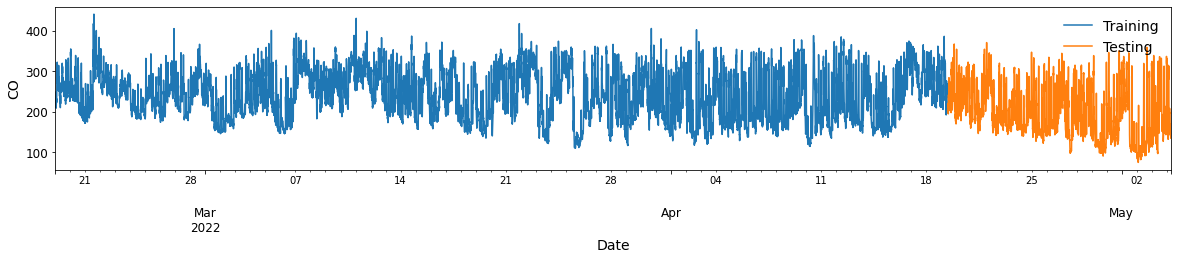

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[ targetSeries ].plot(ax=ax, color='tab:blue' )
df_test[ targetSeries ].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

## Fixing Lag

In [11]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Data transformation

In [12]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = max(df.min().min(), 1.0)
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


## Data scaling

In [13]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = MinMaxScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = RobustScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )  

[INFO] Scaling: Standard
Feature:  NO2


## Create Training/Testing datasets

In [14]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1, includeDate = False):
    
    if (targetSeries is None):
        print('[INFO] Target series is not defined')
        return (None, None, None)
    
    dataX, CurrentValue, dataY = [], [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Instances: Lag-d differences
        Instance  = (df.iloc[i+Lag-1] - df.iloc[i:(i+Lag-1)]).to_numpy().tolist() 
        
        # Include date info
        if (includeDate):            
            myDate = [ np.sin(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist(), 
                       np.cos(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist() ]
            myDate = np.asarray( myDate ).T
            #
            Instance = np.concatenate([Instance, myDate], axis = -1)

        # Current value
        CurrentValue.append( df[ targetSeries ].to_numpy()[i+Lag-1] )
        # Append instance
        dataX.append( Instance ) 
                
        # Target Instance
        Instance = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon])
        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY), np.array(CurrentValue) )

In [15]:
trainX, trainY, _                = create_dataset(df           = df_train, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,
                                                  overlap      = Horizon,)

testX,  testY, test_CurrentValue = create_dataset(df           = df_test, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,                                                
                                                  overlap      = 1)


# trainX = np.expand_dims(trainX, axis=-1)
# testX  = np.expand_dims(testX, axis=-1)
print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4277/4277 [00:01<00:00, 2621.10it/s]

Training instances:     4276
Testing instances:      4277


# Hyperparameter optimization

In [16]:
class Parameter_Evaluation():
    def __init__(self, trainX, testX, trainY, testY, verbose = False):
        # Training/Testing sets
        #
        self.trainX = trainX
        self.testX  = testX
        self.trainY = trainY
        self.testY  = testY
        
        # Parameters
        self.verbose = verbose
        
        # Number of iterations
        #
        self.Iter   = 1
        
        # Best score - initialize
        #
        self.best_score = np.Inf
        
        # Hyperparameter optimization performance
        #
        self.hiplot_data = []
        

        
    def evaluate_params(self, params):
        
        # Store parameters
        #
        self.hiplot_data.append(params)

        
        # Setup model
        #
        model = NBeatsNet(
                  stack_types    = (params['stack_types_0'], params['stack_types_1']),
                  input_dim              = self.trainX.shape[2],
                  forecast_length        = Horizon,
                  backcast_length        = self.trainX.shape[1],
                  hidden_layer_units     = params['hidden_layer_units'],
                  nb_blocks_per_stack    = params['nb_blocks_per_stack'],
                  share_weights_in_stack = params['share_weights_in_stack'],
                  activation_function    = params['activation_function'])
        
        # Define metrics
        #
        metrics = [
                    MeanAbsolutePercentageError(name = "MAPE", dtype = None),
                    RootMeanSquaredError(name = 'RMSE', dtype = None),
                  ]


        model.compile(loss      = params['loss'], 
                      optimizer = Adam(learning_rate = params['lr']), 
                      metrics   = metrics)

        
        # Earlystopping
        earlystopping = EarlyStopping(monitor       = 'val_RMSE', 
                                      mode          = 'min', 
                                      verbose       = False, 
                                      patience      = 20)

        # Learning rate adjustment
        #
        lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_RMSE', 
                                           factor      = 0.5,
                                           patience    = 5)

        # Start clock
        #
        start = time.time()
        
        # Train model
        #
        model.fit(self.trainX, self.trainY,        
                  epochs          = epochs, 
                  batch_size      = params['batch_size'], 
                  callbacks       = [earlystopping, lrs_scheduler],
                  verbose         = self.verbose, 
                  validation_data = (self.testX, self.testY))

        # Terminate clock
        #
        stop = time.time()
        if (self.verbose):
            print('[INFO] Model trained - Time %.2f' % (stop - start))


    
        # Evaluation
        #
        pred        = model.predict( self.trainX ).squeeze(-1)            
        train_score = rmse(self.trainY, pred)
        
        pred        = model.predict( self.testX ).squeeze(-1)
        test_score  = rmse(self.testY, pred)
        
        # Check if test score is valid
        if (np.isnan(test_score)): test_score = 1000
            
        # Export results
        if (test_score < self.best_score):
            print("Iteration: {:3.0f} - RMSE = {:6.3f}/{:6.3f} (train/test) at {} (best)".format(self.Iter, train_score, test_score, str(datetime.now().time())[:8]))
            self.best_score = test_score
        else:
            print("Iteration: {:3.0f} - RMSE = {:6.3f}/{:6.3f} (train/test) at {}".format(self.Iter, train_score, test_score, str(datetime.now().time())[:8]))
        
        # Update Iteration counter
        self.Iter += 1

        # Store score
        self.hiplot_data[-1]['Score'] = test_score
        
        return( test_score )

In [17]:
evaluator = Parameter_Evaluation(trainX  = trainX, 
                                 testX   = testX, 
                                 trainY  = trainY, 
                                 testY   = testY, 
                                 verbose = False)

# Prediction model

## Parameters

In [18]:
# NBeats
search_space = [ skopt.space.Categorical(categories = ['relu', 'elu', 'swish'], 
                                         name="activation_function"),
                 skopt.space.Categorical(categories = [32, 64], 
                                         name="batch_size"),
                 skopt.space.Categorical(categories = [32, 64, 128, 256], 
                                         name="hidden_layer_units"),
                 skopt.space.Categorical(categories = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4], 
                                         name="lr"),
                 skopt.space.Categorical(categories = ['mape', 'mse', 'mae', 'msle'], 
                                         name="loss"),
                 skopt.space.Categorical(categories = [True, False], 
                                         name="share_weights_in_stack"),
                 skopt.space.Categorical(categories = ['generic', 'trend', 'seasonality'], 
                                         name="stack_types_0"),
                 skopt.space.Categorical(categories = ['generic', 'trend', 'seasonality'], 
                                         name="stack_types_1"),

                 skopt.space.Integer(2, 5, 
                                     name='nb_blocks_per_stack'),                
               ]

In [19]:
HPO_params = {
              'n_calls':         n_calls,
              'n_random_starts': n_random_starts,
              'base_estimator':  'ET',
              'acq_func':        'EI',
             }

## Hyperparameter optimization process

In [20]:
@skopt.utils.use_named_args( search_space )
def objective( **params ):
    return  evaluator.evaluate_params( params )

In [21]:
%%time
results = skopt.forest_minimize(objective, search_space, **HPO_params)

2022-05-14 15:26:00.134078: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Iteration:   1 - RMSE =  0.412/ 0.570 (train/test) at 15:29:17 (best)
Iteration:   2 - RMSE =  0.439/ 0.609 (train/test) at 15:29:57
Iteration:   3 - RMSE =  0.439/ 0.609 (train/test) at 15:30:45
Iteration:   4 - RMSE =  0.414/ 0.577 (train/test) at 15:31:38
Iteration:   5 - RMSE =  0.439/ 0.609 (train/test) at 15:32:14
Iteration:   6 - RMSE =  0.412/ 0.578 (train/test) at 15:33:02
Iteration:   7 - RMSE =  0.410/ 0.572 (train/test) at 15:33:50
Iteration:   8 - RMSE =  0.389/ 0.575 (train/test) at 15:34:56
Iteration:   9 - RMSE =  0.439/ 0.609 (train/test) at 15:35:21
Iteration:  10 - RMSE =  0.421/ 0.582 (train/test) at 15:36:03
Iteration:  11 - RMSE =  0.408/ 0.577 (train/test) at 15:36:30
Iteration:  12 - RMSE =  0.439/ 0.608 (train/test) at 15:37:18
Iteration:  13 - RMSE =  0.419/ 0.578 (train/test) at 15:37:37
Iteration:  14 - RMSE =  0.436/ 0.598 (train/test) at 15:38:32
Iteration:  15 - RMSE =  0.413/ 0.569 (train/test) at 15:39:30 (best)
Iteration:  16 - RMSE =  0.439/ 0.609 (tr

Iteration: 122 - RMSE = 3078.169/5086.747 (train/test) at 17:26:06
Iteration: 123 - RMSE =  0.438/ 0.598 (train/test) at 17:26:57
Iteration: 124 - RMSE =  0.412/ 0.568 (train/test) at 17:27:24 (best)
Iteration: 125 - RMSE =    nan/1000.000 (train/test) at 17:28:32
Iteration: 126 - RMSE = 87.143/164.608 (train/test) at 17:29:22
Iteration: 127 - RMSE =  1.041/ 1.505 (train/test) at 17:38:12
Iteration: 128 - RMSE = 48340793937.999/64825032751.202 (train/test) at 17:38:39
Iteration: 129 - RMSE = 20522377392.489/27658356231.055 (train/test) at 17:39:09
Iteration: 130 - RMSE =  0.434/ 0.599 (train/test) at 17:39:51
Iteration: 131 - RMSE =    nan/1000.000 (train/test) at 17:41:01
Iteration: 132 - RMSE = 70692067590972899328.000/99116363082022633472.000 (train/test) at 17:41:59
Iteration: 133 - RMSE =    nan/1000.000 (train/test) at 17:42:49
Iteration: 134 - RMSE =  0.437/ 0.599 (train/test) at 17:44:15
Iteration: 135 - RMSE =  0.437/ 0.598 (train/test) at 17:44:51
Iteration: 136 - RMSE = 9737

### Plot results - Convergence

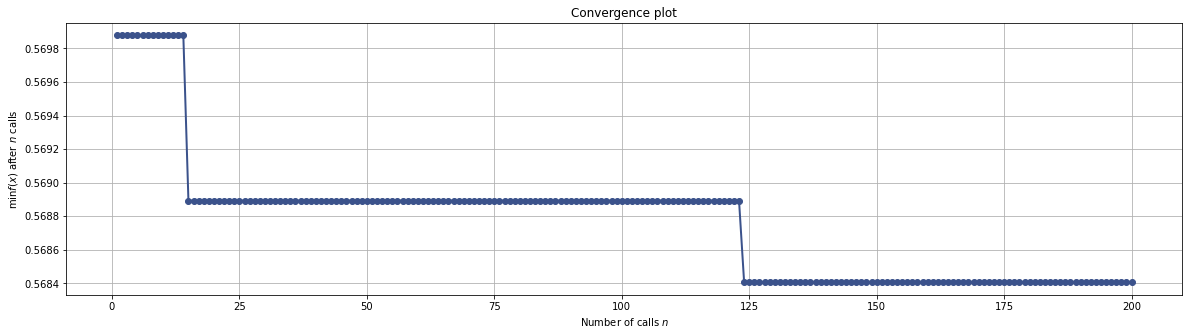

In [22]:
plt.figure( figsize=(20, 5) )

skopt.plots.plot_convergence(results);

### Plot results - Evaluations

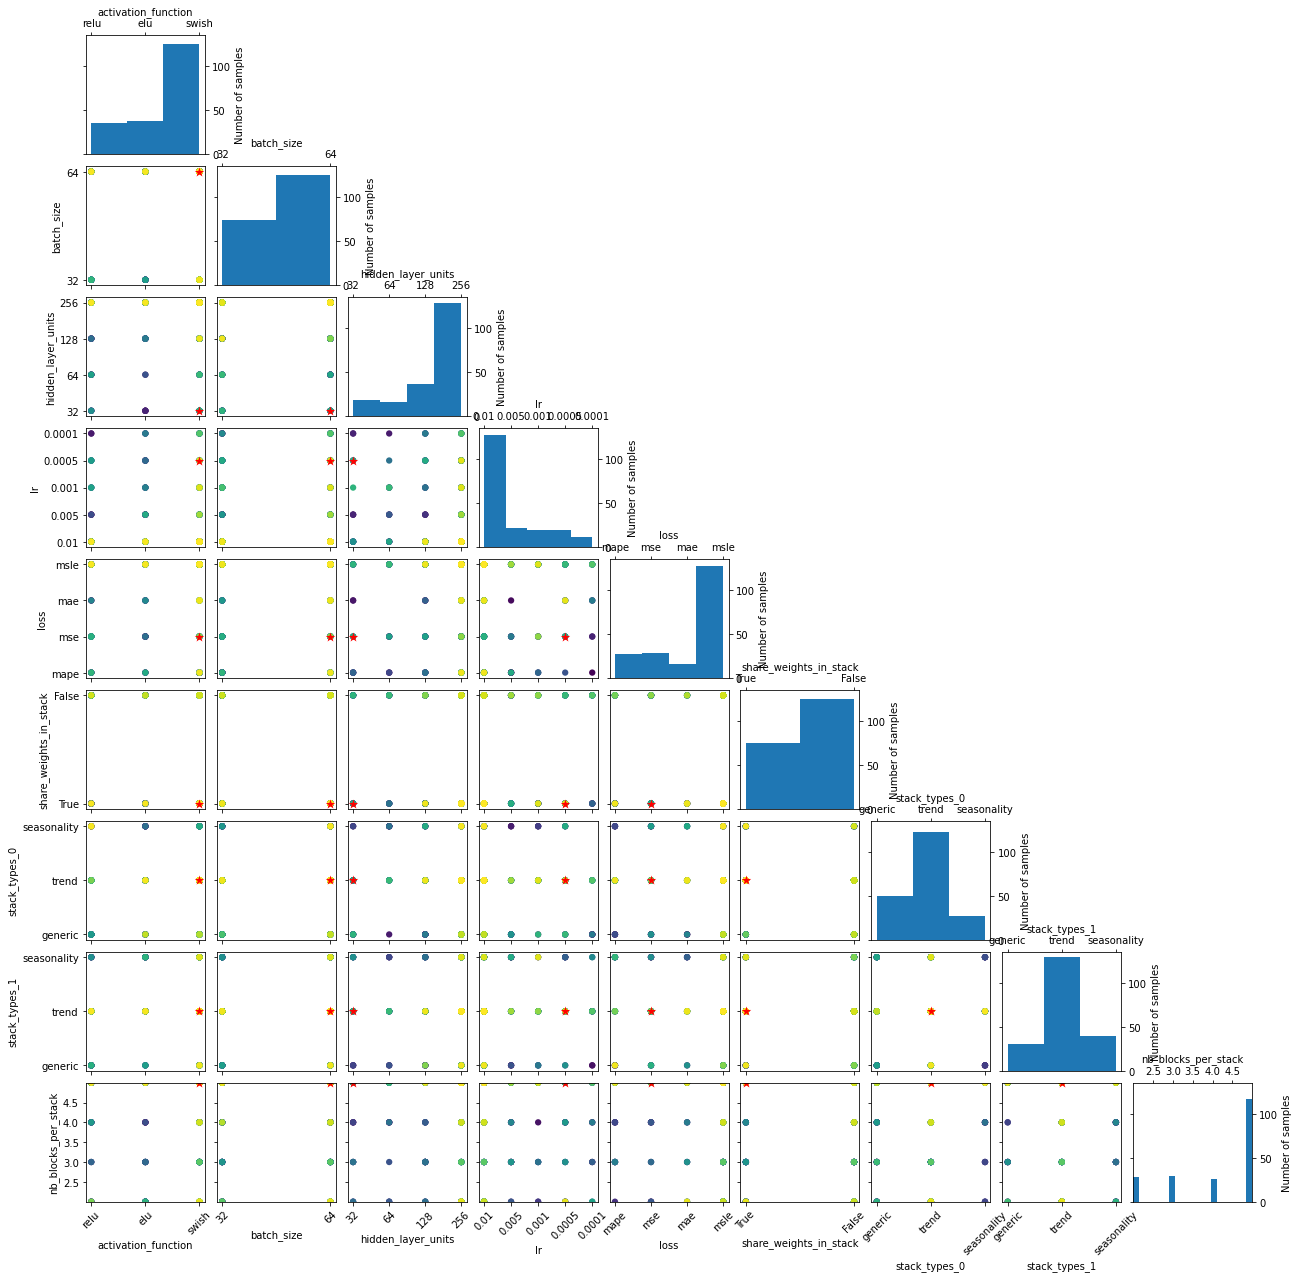

In [23]:
skopt.plots.plot_evaluations(results);

In [24]:
# skopt.plots.plot_objective(results)

### Interactive parallel coordinates plots

In [25]:
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

# Convert NumPy data types to be recognizable by json
evaluator.hiplot_data = json.loads( json.dumps(evaluator.hiplot_data, default=np_encoder) )

In [26]:
hip.Experiment.from_iterable( evaluator.hiplot_data ).display();

<IPython.core.display.Javascript object>

### Save results

In [27]:
with open('models/Hyperparameter_optimization.json', 'w', encoding='utf-8') as f:
    f.write( json.dumps( evaluator.hiplot_data ) )

## Get optimized hyperparameters

In [28]:
def to_named_params(results, search_space):
    params       = results.x
    param_dict   = {}
    
    params_list  =[(dimension.name, param) for dimension, param in zip(search_space, params)]
    
    for item in params_list:
        param_dict[item[0]] = item[1]
    
    return( param_dict )

In [29]:
optimized_params = to_named_params(results, search_space)


print('[INFO] Optimized hyperparameters\n')
#
for (parameter,value) in optimized_params.items():
    if ( isinstance(value, float) ):
        print(' >%25s: %.5f' % (parameter,value))
    else:
        print(' >%25s: %s' % (parameter,value))

[INFO] Optimized hyperparameters

 >      activation_function: swish
 >               batch_size: 64
 >       hidden_layer_units: 32
 >                       lr: 0.00050
 >                     loss: mse
 >   share_weights_in_stack: True
 >            stack_types_0: trend
 >            stack_types_1: trend
 >      nb_blocks_per_stack: 5


# Optimized (best) model setup

In [30]:
# Setup model
#
model = NBeatsNet(stack_types    = (optimized_params['stack_types_0'], optimized_params['stack_types_1']),
                  #
                  input_dim              = trainX.shape[2],
                  forecast_length        = Horizon,
                  backcast_length        = trainX.shape[1],
                  hidden_layer_units     = optimized_params['hidden_layer_units'],
                  nb_blocks_per_stack    = optimized_params['nb_blocks_per_stack'],
                  share_weights_in_stack = optimized_params['share_weights_in_stack'],
                  activation_function    = optimized_params['activation_function'])


print('[INFO] Model trained')

[INFO] Model trained


## Setup training parameters

In [31]:
# Define metrics
#
metrics = [
            MeanAbsolutePercentageError(name = "MAPE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss      = optimized_params['loss'], 
              optimizer = Adam(learning_rate = optimized_params['lr']), 
              metrics   = metrics)


# Checkpoint
#
checkpoint = ModelCheckpoint("models/NBeats_Diff.hdf5", 
                              monitor        = 'val_RMSE', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_RMSE', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_RMSE', 
                                   factor      = 0.5,
                                   patience    = 5)



## Train model

In [32]:
# Start clock
#
start = time.time()


score = model.fit(trainX, trainY, 
                  epochs          = epochs, 
                  batch_size      = optimized_params['batch_size'], 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  verbose         = True, 
                  validation_data = (testX, testY))


# Terminate clock
#
stop = time.time()
print('[INFO] Time %.2f' % (stop - start))

Epoch 1/300
67/67 [==============================] - 11s 36ms/step - loss: 0.1877 - MAPE: 69060.4141 - RMSE: 0.4332 - val_loss: 0.3420 - val_MAPE: 44272.7031 - val_RMSE: 0.5849 - lr: 5.0000e-04
Epoch 2/300
67/67 [==============================] - 1s 9ms/step - loss: 0.1821 - MAPE: 82871.5469 - RMSE: 0.4267 - val_loss: 0.3371 - val_MAPE: 51510.2617 - val_RMSE: 0.5806 - lr: 5.0000e-04
Epoch 3/300
67/67 [==============================] - 1s 8ms/step - loss: 0.1806 - MAPE: 90674.9609 - RMSE: 0.4250 - val_loss: 0.3356 - val_MAPE: 58061.4570 - val_RMSE: 0.5793 - lr: 5.0000e-04
Epoch 4/300
67/67 [==============================] - 1s 8ms/step - loss: 0.1794 - MAPE: 100760.6406 - RMSE: 0.4235 - val_loss: 0.3339 - val_MAPE: 57609.4648 - val_RMSE: 0.5778 - lr: 5.0000e-04
Epoch 5/300
67/67 [==============================] - 1s 9ms/step - loss: 0.1784 - MAPE: 102480.5391 - RMSE: 0.4224 - val_loss: 0.3318 - val_MAPE: 65780.7031 - val_RMSE: 0.5760 - lr: 5.0000e-04
Epoch 6/300
67/67 [=================

## Training performance

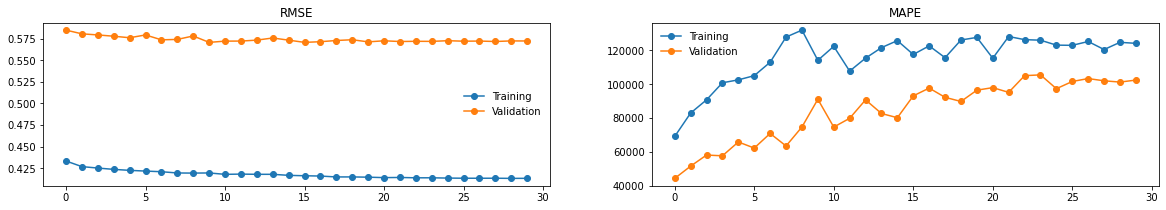

In [33]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'], marker = 'o');
ax[0].plot( score.history['val_RMSE'], marker = 'o');
ax[0].legend(['Training', 'Validation'], frameon = False);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAPE'], marker = 'o');
ax[1].plot( score.history['val_MAPE'], marker = 'o');
ax[1].legend(['Training', 'Validation'], frameon = False);
ax[1].set_title('MAPE');

## Evaluation

### Load optimized model

In [34]:
# Load the best model
#
model.load_weights('models/NBeats_Diff.hdf5')

print('[INFO] Model loaded')

[INFO] Model loaded


### Get predictions

In [35]:
# Get predictions
#
pred = model.predict( testX ).squeeze(-1)

### Inverse "Lag-d Diff" transformation

In [36]:
for i in range( Horizon ):
    testY[:, i] = test_CurrentValue - testY[:, i]
    pred[:, i]  = test_CurrentValue - pred[:, i]

### Apply inverse scaling/transformation

In [37]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set - Prediction visualization

In [38]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[:, i] 



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE  ]
    Performance_Foresting_Model['MAE']     += [ MAE   ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE ]
    Performance_Foresting_Model['R2']      += [ R2    ]

#     # Present results
#     #
#     print('Horizon: ', i+1)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, SMAPE, R2) )

[INFO] Feature:  CO
------------------------------------------------
Horizon:  1 MAE 10.02 SMAPE:  4.88 R2: 0.93
Horizon:  2 MAE 17.35 SMAPE:  8.41 R2: 0.81
Horizon:  3 MAE 22.30 SMAPE: 10.84 R2: 0.69
Horizon:  4 MAE 26.38 SMAPE: 12.88 R2: 0.58


### Prediction visualization

[INFO] Feature:  CO
------------------------------------------------


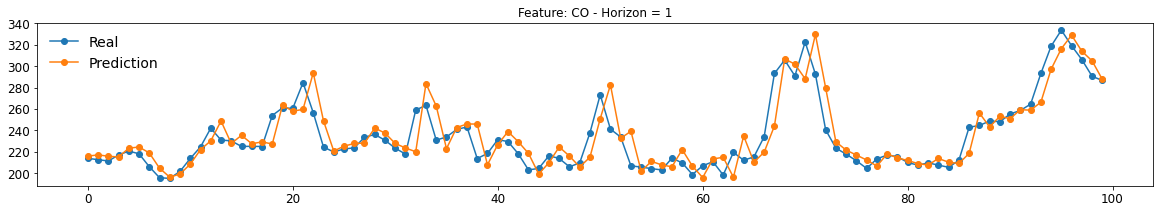

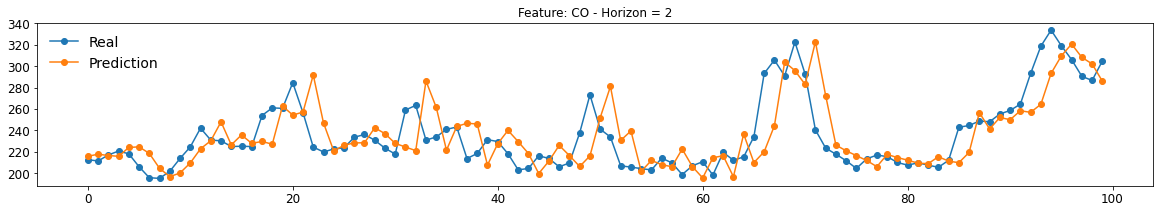

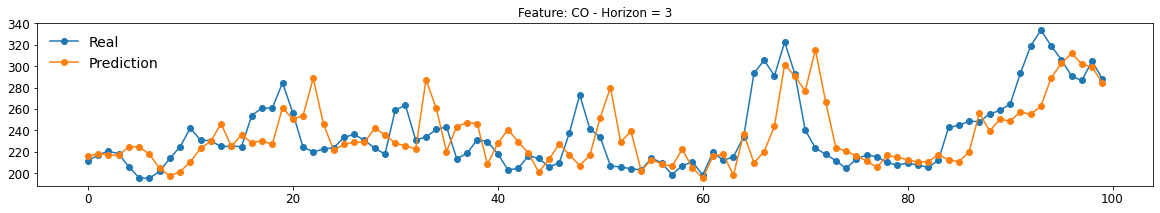

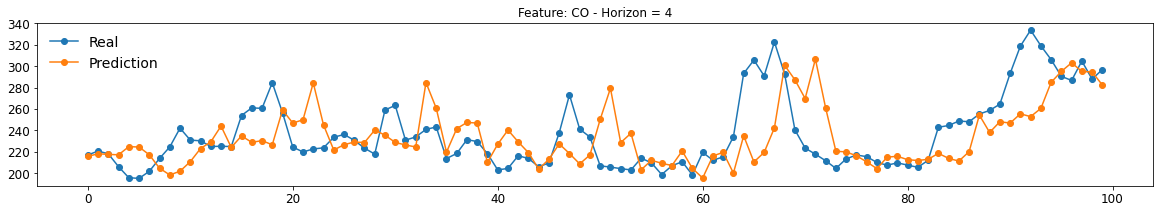

In [39]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[:, i] 
            
    
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

### Residual analysis

[INFO] Feature:  CO
------------------------------------------------


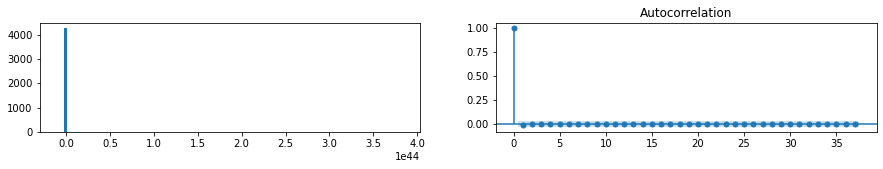

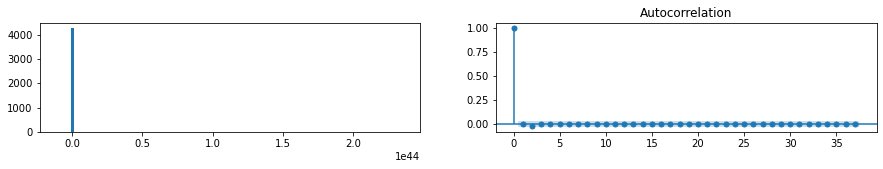

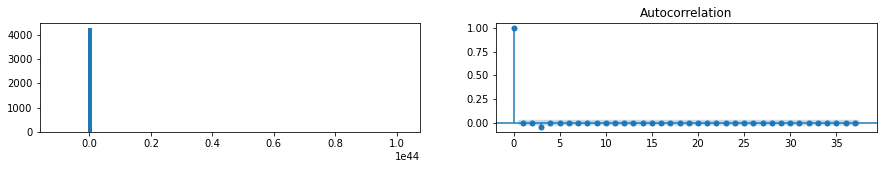

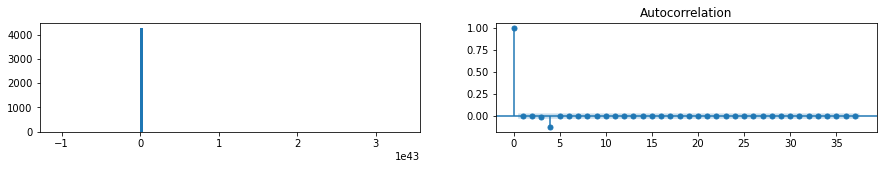

In [40]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )


    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )
            

            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices['Prediction'] - Prices['Real']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )      

### Examples

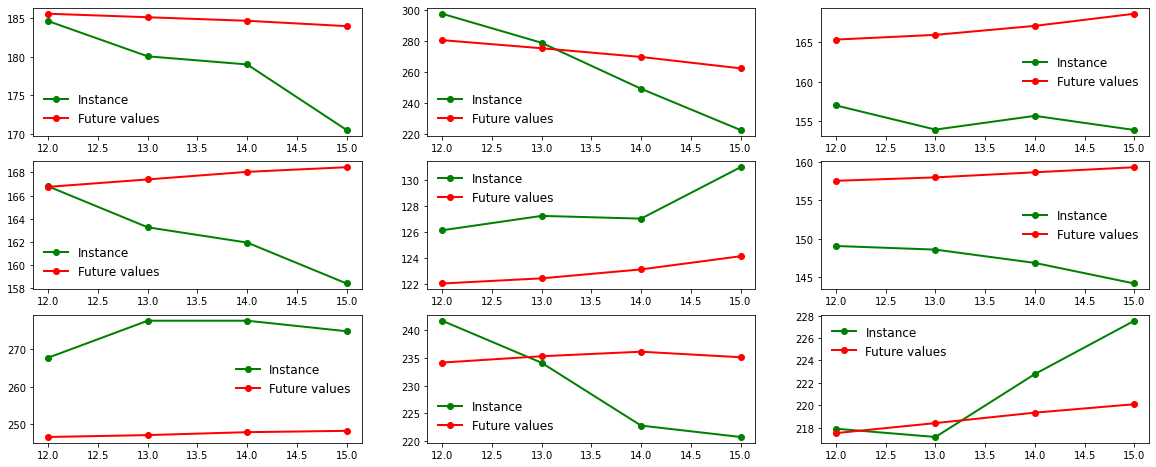

In [41]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()